<a href="https://colab.research.google.com/github/manamendraJN/model/blob/main/bodyM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📋 Step 1: Environment Setup & Data Loading**

**1.1 Install Required Libraries**

In [40]:
!pip install -q pandas numpy opencv-python scikit-learn matplotlib seaborn albumentations pillow

import pandas as pd
import numpy as np
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import albumentations as A
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**1.2 Verify Uploaded Files**

In [41]:
# Since files are already uploaded, verify the structure
print("📁 Verifying dataset structure...\n")

# Check if CSV files exist
csv_files = ['subject_to_photo_map.csv', 'measurements.csv', 'hwg_metadata.csv']
for csv_file in csv_files:
    if os.path.exists(f'/content/{csv_file}'):
        print(f"✓ Found: {csv_file}")
    else:
        print(f"✗ Missing: {csv_file}")

# Check for image folders
image_dirs = {
    'front_view': '/content/mask',
    'side_view': '/content/mask_left'
}

for view_name, dir_path in image_dirs.items():
    if os.path.exists(dir_path):
        num_images = len([f for f in os.listdir(dir_path) if f.endswith('.png')])
        print(f"✓ Found: {view_name} folder with {num_images} images")
    else:
        print(f"✗ Missing: {view_name} folder at {dir_path}")

📁 Verifying dataset structure...

✓ Found: subject_to_photo_map.csv
✓ Found: measurements.csv
✓ Found: hwg_metadata.csv
✓ Found: front_view folder with 6134 images
✓ Found: side_view folder with 6134 images


# **🔍 Step 2: Data Exploration & Diagnosis**

**2.1 Load and Inspect CSV Files**

In [42]:
print("\n" + "="*70)
print("LOADING CSV FILES")
print("="*70)

# Load CSV files with proper handling
subject_to_photo = pd.read_csv('/content/subject_to_photo_map.csv')
measurements = pd.read_csv('/content/measurements.csv')
metadata = pd.read_csv('/content/hwg_metadata.csv')

# Display basic information
print("\n📊 SUBJECT TO PHOTO MAP")
print(f"Shape: {subject_to_photo.shape}")
print(f"Columns: {list(subject_to_photo.columns)}")
print(f"\nFirst 3 rows:")
print(subject_to_photo.head(3))
print(f"\nUnique subjects: {subject_to_photo['subject_id'].nunique()}")
print(f"Total photo-subject mappings: {len(subject_to_photo)}")

print("\n📊 MEASUREMENTS")
print(f"Shape: {measurements.shape}")
print(f"Columns: {list(measurements.columns)}")
print(f"\nFirst 3 rows:")
print(measurements.head(3))
print(f"\nUnique subjects with measurements: {measurements['subject_id'].nunique()}")

print("\n📊 METADATA")
print(f"Shape: {metadata.shape}")
print(f"Columns: {list(metadata.columns)}")
print(f"\nFirst 3 rows:")
print(metadata.head(3))
print(f"\nGender distribution:")
print(metadata['gender'].value_counts())


LOADING CSV FILES

📊 SUBJECT TO PHOTO MAP
Shape: (6134, 2)
Columns: ['subject_id', 'photo_id']

First 3 rows:
                                    subject_id  \
0  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg   
1  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg   
2  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg   

                           photo_id  
0  e6f404ebda41ebe93573d3e219c88297  
1  39a4241cb892618a694747e224d57b9e  
2  a00a6c0c074efbd92c894cbc77023939  

Unique subjects: 2018
Total photo-subject mappings: 6134

📊 MEASUREMENTS
Shape: (2018, 15)
Columns: ['subject_id', 'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'height', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist']

First 3 rows:
                                    subject_id      ankle  arm-length  \
0  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg  24.343954   52.902378   
1  -5OHO2b5mRDY1rvAf07sYYtekEEX7ViEGmvRr7l4tfc  22.001783   46.763233   
2  -5iHTazqnmWBsnUY6ymoCw1

**2.2 Critical: Check Column Names and Data Types**

In [43]:
print("\n" + "="*70)
print("DATA TYPE DIAGNOSIS")
print("="*70)

# Clean column names (remove extra whitespace)
subject_to_photo.columns = subject_to_photo.columns.str.strip()
measurements.columns = measurements.columns.str.strip()
metadata.columns = metadata.columns.str.strip()

print("\n✓ Column names cleaned")

# Check for subject_id formatting issues
print("\n🔍 Subject ID Analysis:")
print(f"Subject IDs in map - first: '{subject_to_photo['subject_id'].iloc[0]}'")
print(f"Subject IDs in measurements - first: '{measurements['subject_id'].iloc[0]}'")
print(f"Subject IDs in metadata - first: '{metadata['subject_id'].iloc[0]}'")

# Check data types
print("\n📋 Measurements data types:")
print(measurements.dtypes)

# Check for null values
print("\n⚠️  Null values in measurements:")
print(measurements.isnull().sum())

# Get measurement column names (exclude subject_id)
measurement_cols = [col for col in measurements.columns if col != 'subject_id']
print(f"\n📏 Measurement columns ({len(measurement_cols)}): {measurement_cols}")

# Verify measurements are numeric
print("\n🔢 Checking if measurements are numeric...")
for col in measurement_cols:
    if not pd.api.types.is_numeric_dtype(measurements[col]):
        print(f"⚠️  '{col}' is NOT numeric - converting...")
        measurements[col] = pd.to_numeric(measurements[col], errors='coerce')
    else:
        print(f"✓ '{col}' is numeric")

# Display measurement statistics
print("\n📊 Measurement Statistics:")
print(measurements[measurement_cols].describe())


DATA TYPE DIAGNOSIS

✓ Column names cleaned

🔍 Subject ID Analysis:
Subject IDs in map - first: '-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg'
Subject IDs in measurements - first: '-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg'
Subject IDs in metadata - first: 'AhfyGaD1BKo0-u6PeQk2oI-Bw5l0XxpAqNroFuZuy0I'

📋 Measurements data types:
subject_id             object
ankle                 float64
arm-length            float64
bicep                 float64
calf                  float64
chest                 float64
forearm               float64
height                float64
hip                   float64
leg-length            float64
shoulder-breadth      float64
shoulder-to-crotch    float64
thigh                 float64
waist                 float64
wrist                 float64
dtype: object

⚠️  Null values in measurements:
subject_id            0
ankle                 0
arm-length            0
bicep                 0
calf                  0
chest                 0
forearm               0
h

# **🔗 Step 3: Data Alignment & Merging**

**3.1 Merge All Data Sources**

In [44]:
print("\n" + "="*70)
print("MERGING DATA SOURCES")
print("="*70)

# Strip whitespace from subject_ids to avoid matching issues
subject_to_photo['subject_id'] = subject_to_photo['subject_id'].str.strip()
measurements['subject_id'] = measurements['subject_id'].str.strip()
metadata['subject_id'] = metadata['subject_id'].str.strip()

# Also strip photo_id
subject_to_photo['photo_id'] = subject_to_photo['photo_id'].str.strip()

print(f"\n📍 Before merge:")
print(f"  Subject-Photo mappings: {len(subject_to_photo)}")
print(f"  Subjects with measurements: {measurements['subject_id'].nunique()}")
print(f"  Subjects with metadata: {metadata['subject_id'].nunique()}")

# Step 1: Merge subject_to_photo with measurements
df = subject_to_photo.merge(
    measurements,
    on='subject_id',
    how='inner'  # Only keep subjects that have measurements
)

print(f"\n✓ After merging with measurements: {len(df)} rows")

# Step 2: Merge with metadata
df = df.merge(
    metadata,
    on='subject_id',
    how='left'  # Keep all even if no metadata
)

print(f"✓ After merging with metadata: {len(df)} rows")

# Check overlap
print(f"\n📊 Merge Summary:")
print(f"  Total rows: {len(df)}")
print(f"  Unique subjects: {df['subject_id'].nunique()}")
print(f"  Unique photos: {df['photo_id'].nunique()}")

# Display sample
print(f"\n📋 Sample of merged data:")
print(df.head(3))

# Check for null values after merge
print(f"\n⚠️  Null values after merge:")
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])


MERGING DATA SOURCES

📍 Before merge:
  Subject-Photo mappings: 6134
  Subjects with measurements: 2018
  Subjects with metadata: 2018

✓ After merging with measurements: 6134 rows
✓ After merging with metadata: 6134 rows

📊 Merge Summary:
  Total rows: 6134
  Unique subjects: 2018
  Unique photos: 6134

📋 Sample of merged data:
                                    subject_id  \
0  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg   
1  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg   
2  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg   

                           photo_id      ankle  arm-length      bicep  \
0  e6f404ebda41ebe93573d3e219c88297  24.343954   52.902378  33.294395   
1  39a4241cb892618a694747e224d57b9e  24.343954   52.902378  33.294395   
2  a00a6c0c074efbd92c894cbc77023939  24.343954   52.902378  33.294395   

        calf       chest    forearm      height         hip  leg-length  \
0  38.709511  102.526024  27.599094  177.610992  108.047134   81.736435   
1  38.709511  102.526024

**3.2 Add Image Paths and Validate Existence**

In [45]:
print("\n" + "="*70)
print("IMAGE PATH VALIDATION")
print("="*70)

# Define image directories
FRONT_DIR = '/content/mask'
SIDE_DIR = '/content/mask_left'

# Function to construct image path
def get_image_path(photo_id, view='front'):
    """Construct image path and check multiple extensions"""
    base_dir = FRONT_DIR if view == 'front' else SIDE_DIR

    # Try different extensions
    for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG']:
        path = os.path.join(base_dir, f"{photo_id}{ext}")
        if os.path.exists(path):
            return path

    # If not found, return expected path
    return os.path.join(base_dir, f"{photo_id}.png")

# Add image paths
df['front_image_path'] = df['photo_id'].apply(lambda x: get_image_path(x, 'front'))
df['side_image_path'] = df['photo_id'].apply(lambda x: get_image_path(x, 'side'))

# Check if images exist
df['front_exists'] = df['front_image_path'].apply(os.path.exists)
df['side_exists'] = df['side_image_path'].apply(os.path.exists)

print(f"📸 Image Availability:")
print(f"  Rows with front image: {df['front_exists'].sum()} / {len(df)}")
print(f"  Rows with side image: {df['side_exists'].sum()} / {len(df)}")
print(f"  Rows with BOTH images: {(df['front_exists'] & df['side_exists']).sum()} / {len(df)}")

# Show examples of missing images
missing_front = df[~df['front_exists']]['photo_id'].head(3).tolist()
missing_side = df[~df['side_exists']]['photo_id'].head(3).tolist()

if missing_front:
    print(f"\n⚠️  Sample missing front images: {missing_front}")
if missing_side:
    print(f"⚠️  Sample missing side images: {missing_side}")

# Filter to only rows with both images
df_clean = df[df['front_exists'] & df['side_exists']].copy()

print(f"\n✓ Final clean dataset: {len(df_clean)} rows with both images")
print(f"  Representing {df_clean['subject_id'].nunique()} unique subjects")

# Check measurement statistics on clean data
print(f"\n📏 Measurement statistics on clean data:")
print(df_clean[measurement_cols].describe().round(2))


IMAGE PATH VALIDATION
📸 Image Availability:
  Rows with front image: 6134 / 6134
  Rows with side image: 6134 / 6134
  Rows with BOTH images: 6134 / 6134

✓ Final clean dataset: 6134 rows with both images
  Representing 2018 unique subjects

📏 Measurement statistics on clean data:
         ankle  arm-length    bicep     calf    chest  forearm   height  \
count  6134.00     6134.00  6134.00  6134.00  6134.00  6134.00  6134.00   
mean     24.22       49.59    30.65    37.52   102.23    26.62   172.18   
std       1.87        3.24     4.06     3.26    11.42     2.72     9.58   
min      19.24       39.39    19.13    28.27    77.08    18.88   140.86   
25%      22.85       47.31    27.91    35.25    94.27    24.70   165.05   
50%      24.24       49.71    30.41    37.26   101.48    26.63   172.39   
75%      25.48       51.70    32.86    39.41   108.49    28.38   179.08   
max      32.98       59.43    55.81    55.33   153.94    39.75   197.51   

           hip  leg-length  shoulder-brea

# **🖼️ Step 4: Image Preprocessing & Visualization**

**4.1 Image Loading Function**

In [46]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

def load_and_preprocess_image(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Load and preprocess a single image

    Args:
        image_path: Path to image file
        target_size: Tuple of (height, width)

    Returns:
        Preprocessed image array or None if loading fails
    """
    try:
        # Read image using OpenCV
        img = cv2.imread(image_path)

        if img is None:
            print(f"⚠️  Failed to load: {image_path}")
            return None

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to target size
        img = cv2.resize(img, (target_size[1], target_size[0]),
                        interpolation=cv2.INTER_AREA)

        # Normalize to [0, 1]
        img = img.astype(np.float32) / 255.0

        return img

    except Exception as e:
        print(f"❌ Error loading {image_path}: {str(e)}")
        return None

print("✓ Image loading function defined")

✓ Image loading function defined


**4.2 Visualize Sample Images**


VISUALIZING SAMPLE IMAGES


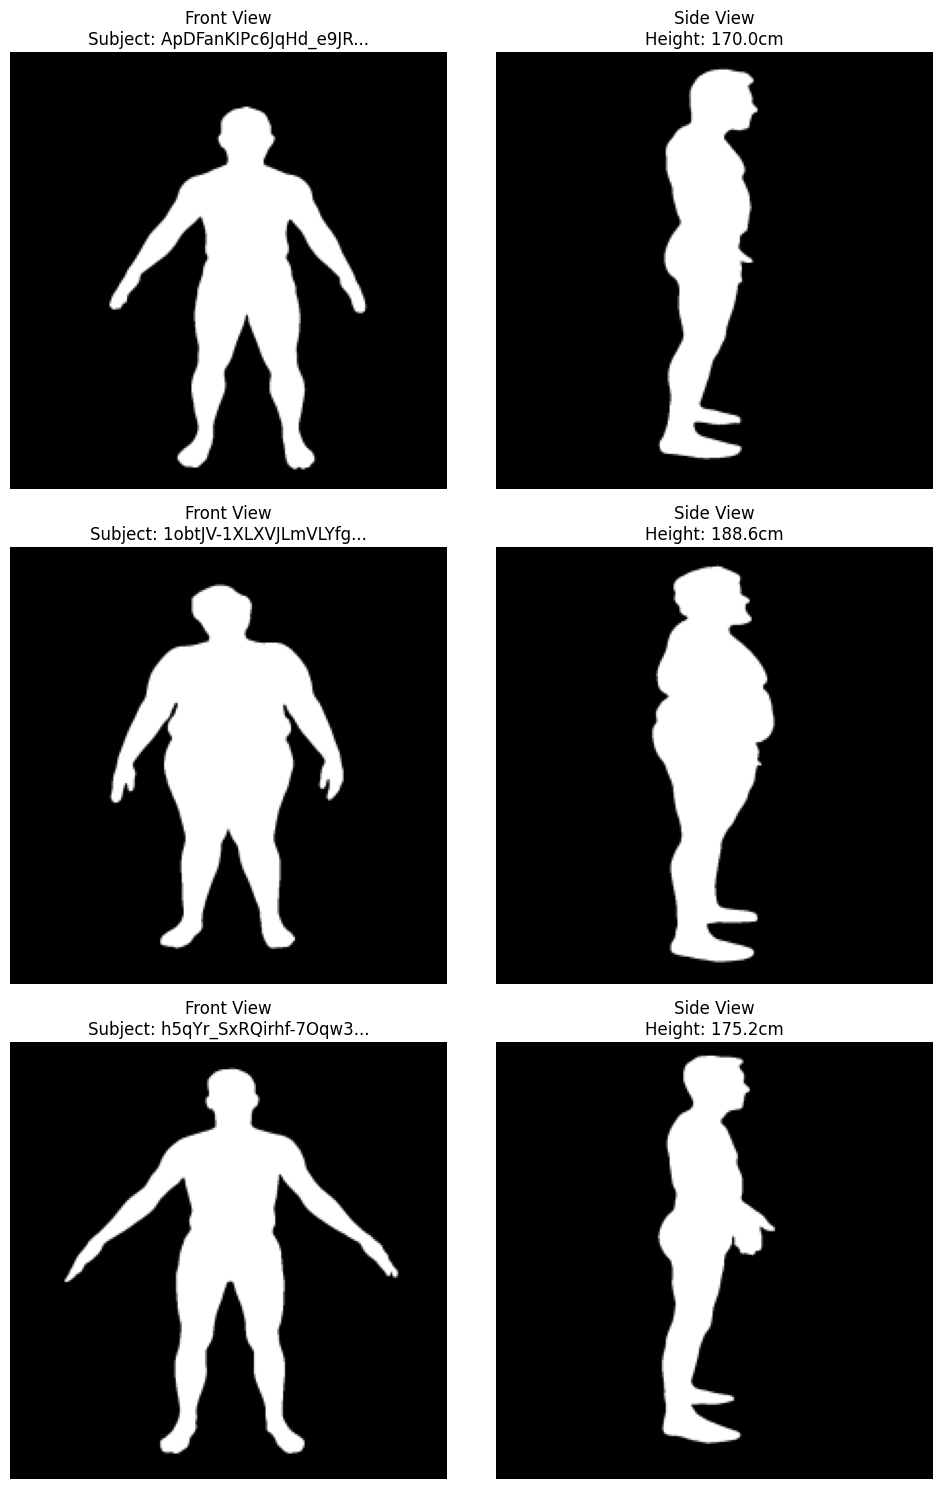

✓ Displayed 3 sample image pairs


In [47]:
print("\n" + "="*70)
print("VISUALIZING SAMPLE IMAGES")
print("="*70)

# Select random samples to visualize
num_samples = 3
sample_indices = np.random.choice(len(df_clean), size=min(num_samples, len(df_clean)), replace=False)

fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
if num_samples == 1:
    axes = axes.reshape(1, -1)

for idx, sample_idx in enumerate(sample_indices):
    row = df_clean.iloc[sample_idx]

    # Load images
    front_img = load_and_preprocess_image(row['front_image_path'])
    side_img = load_and_preprocess_image(row['side_image_path'])

    if front_img is not None:
        axes[idx, 0].imshow(front_img)
        axes[idx, 0].set_title(f'Front View\nSubject: {row["subject_id"][:20]}...')
        axes[idx, 0].axis('off')

    if side_img is not None:
        axes[idx, 1].imshow(side_img)
        axes[idx, 1].set_title(f'Side View\nHeight: {row["height"]:.1f}cm')
        axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"✓ Displayed {num_samples} sample image pairs")

**4.3 Analyze Image Properties**

In [48]:
print("\n📐 Analyzing image properties...")

# Sample a subset for analysis
sample_size = min(50, len(df_clean))
sample_df = df_clean.sample(n=sample_size, random_state=42)

image_shapes = []
image_channels = []

for _, row in sample_df.iterrows():
    # Check front image
    img = cv2.imread(row['front_image_path'])
    if img is not None:
        image_shapes.append(img.shape[:2])  # (height, width)
        image_channels.append(img.shape[2] if len(img.shape) == 3 else 1)

if image_shapes:
    shapes_array = np.array(image_shapes)
    print(f"\n📊 Image Dimensions (from {sample_size} samples):")
    print(f"  Height - Min: {shapes_array[:, 0].min()}, Max: {shapes_array[:, 0].max()}, Mean: {shapes_array[:, 0].mean():.1f}")
    print(f"  Width  - Min: {shapes_array[:, 1].min()}, Max: {shapes_array[:, 1].max()}, Mean: {shapes_array[:, 1].mean():.1f}")
    print(f"  Channels: {set(image_channels)}")
    print(f"\n✓ All images will be resized to {IMG_HEIGHT}x{IMG_WIDTH}")


📐 Analyzing image properties...

📊 Image Dimensions (from 50 samples):
  Height - Min: 960, Max: 960, Mean: 960.0
  Width  - Min: 720, Max: 720, Mean: 720.0
  Channels: {3}

✓ All images will be resized to 224x224


# **🎯 Step 5: Data Augmentation Strategy**

**5.1 Define Augmentation Pipeline**

In [49]:
def get_augmentation_pipeline(is_training=True):
    """
    Create augmentation pipeline using Albumentations

    Args:
        is_training: If True, apply training augmentations

    Returns:
        Albumentations Compose object or None
    """
    if is_training:
        return A.Compose([
            # Geometric transformations
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.05,
                scale_limit=0.1,
                rotate_limit=10,
                border_mode=cv2.BORDER_CONSTANT,
                p=0.5
            ),

            # Color augmentations
            A.RandomBrightnessContrast(
                brightness_limit=0.2,
                contrast_limit=0.2,
                p=0.3
            ),
            A.HueSaturationValue(
                hue_shift_limit=10,
                sat_shift_limit=20,
                val_shift_limit=10,
                p=0.3
            ),

            # Noise and blur
            A.GaussianBlur(blur_limit=(3, 5), p=0.2),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),

            # Dropout augmentation
            A.CoarseDropout(
                max_holes=8,
                max_height=16,
                max_width=16,
                min_holes=1,
                fill_value=0,
                p=0.2
            ),
        ])
    else:
        return None

def apply_augmentation(image, augmentation_pipeline):
    """Apply augmentation to a preprocessed image"""
    if augmentation_pipeline is not None:
        # Convert to uint8 for albumentations
        image_uint8 = (image * 255).astype(np.uint8)
        augmented = augmentation_pipeline(image=image_uint8)
        # Convert back to float32
        return augmented['image'].astype(np.float32) / 255.0
    return image

print("✓ Augmentation pipeline defined")

✓ Augmentation pipeline defined


**5.2 Visualize Augmentations**


VISUALIZING AUGMENTATIONS


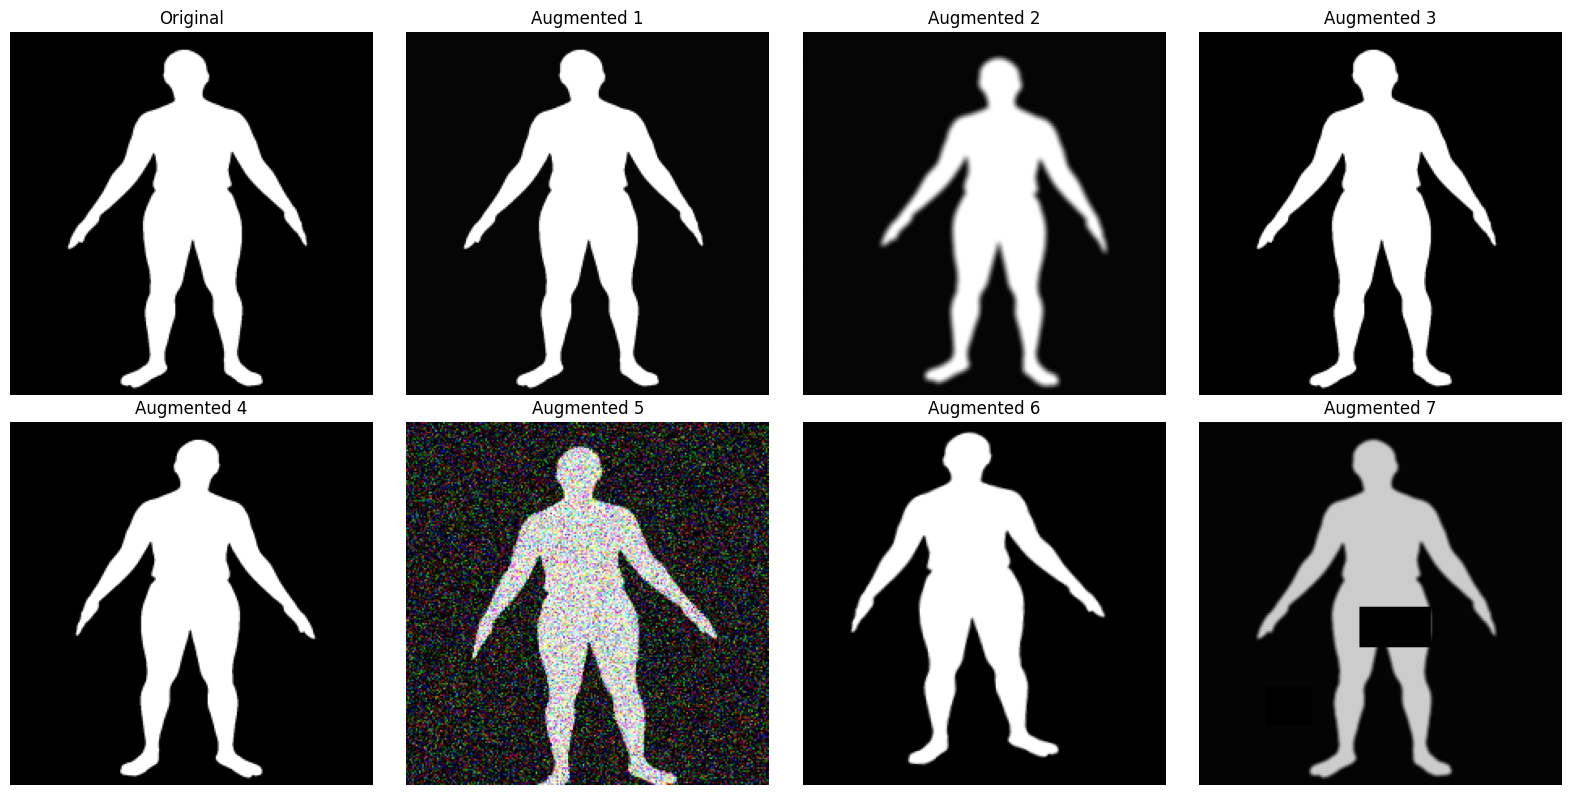

✓ Augmentation examples displayed


In [50]:
print("\n" + "="*70)
print("VISUALIZING AUGMENTATIONS")
print("="*70)

# Load a sample image
sample_row = df_clean.iloc[0]
original_img = load_and_preprocess_image(sample_row['front_image_path'])

if original_img is not None:
    aug_pipeline = get_augmentation_pipeline(is_training=True)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    # Show original
    axes[0].imshow(original_img)
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Show augmented versions
    for i in range(1, 8):
        aug_img = apply_augmentation(original_img, aug_pipeline)
        axes[i].imshow(aug_img)
        axes[i].set_title(f'Augmented {i}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    print("✓ Augmentation examples displayed")

# **📊 Step 6: Train-Validation-Test Split**

**6.1 Split Data by Subject**

In [51]:
print("\n" + "="*70)
print("CREATING DATA SPLITS")
print("="*70)

# CRITICAL: Split by subject_id to prevent data leakage
# (same person's photos should not be in both train and test)

unique_subjects = df_clean['subject_id'].unique()
print(f"📍 Total unique subjects: {len(unique_subjects)}")

# First split: 70% train, 30% temp
train_subjects, temp_subjects = train_test_split(
    unique_subjects,
    test_size=0.30,
    random_state=42,
    shuffle=True
)

# Second split: Split temp into 50-50 (15% val, 15% test of total)
val_subjects, test_subjects = train_test_split(
    temp_subjects,
    test_size=0.50,
    random_state=42,
    shuffle=True
)

# Create split dataframes
train_df = df_clean[df_clean['subject_id'].isin(train_subjects)].reset_index(drop=True)
val_df = df_clean[df_clean['subject_id'].isin(val_subjects)].reset_index(drop=True)
test_df = df_clean[df_clean['subject_id'].isin(test_subjects)].reset_index(drop=True)

print(f"\n📊 Split Summary:")
print(f"  Train: {len(train_df)} samples from {len(train_subjects)} subjects ({len(train_subjects)/len(unique_subjects)*100:.1f}%)")
print(f"  Val:   {len(val_df)} samples from {len(val_subjects)} subjects ({len(val_subjects)/len(unique_subjects)*100:.1f}%)")
print(f"  Test:  {len(test_df)} samples from {len(test_subjects)} subjects ({len(test_subjects)/len(unique_subjects)*100:.1f}%)")

# Verify no subject overlap
assert len(set(train_subjects) & set(val_subjects)) == 0, "Train-Val overlap detected!"
assert len(set(train_subjects) & set(test_subjects)) == 0, "Train-Test overlap detected!"
assert len(set(val_subjects) & set(test_subjects)) == 0, "Val-Test overlap detected!"
print("\n✓ No subject overlap between splits - data leakage prevented!")

# Check distribution balance
print("\n📊 Gender Distribution:")
for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    if 'gender' in split_df.columns:
        gender_dist = split_df['gender'].value_counts()
        print(f"  {split_name}: {gender_dist.to_dict()}")


CREATING DATA SPLITS
📍 Total unique subjects: 2018

📊 Split Summary:
  Train: 4316 samples from 1412 subjects (70.0%)
  Val:   859 samples from 303 subjects (15.0%)
  Test:  959 samples from 303 subjects (15.0%)

✓ No subject overlap between splits - data leakage prevented!

📊 Gender Distribution:
  Train: {'male': 2555, 'female': 1761}
  Val: {'male': 524, 'female': 335}
  Test: {'male': 571, 'female': 388}


**6.2 Normalize Measurements**

In [52]:
print("\n" + "="*70)
print("NORMALIZING MEASUREMENTS")
print("="*70)

# Fit scaler on TRAINING data only
scaler = StandardScaler()
train_measurements = train_df[measurement_cols].values
scaler.fit(train_measurements)

# Transform all splits
train_df[measurement_cols] = scaler.transform(train_df[measurement_cols])
val_df[measurement_cols] = scaler.transform(val_df[measurement_cols])
test_df[measurement_cols] = scaler.transform(test_df[measurement_cols])

print("✓ Measurements normalized using StandardScaler")
print(f"\n📏 Scaler Statistics (first 5 measurements):")
print(f"  Mean: {scaler.mean_[:5].round(2)}")
print(f"  Std:  {scaler.scale_[:5].round(2)}")

# Verify normalization
print(f"\n📊 Training data after normalization:")
print(f"  Mean: {train_df[measurement_cols].mean().mean():.4f} (should be ~0)")
print(f"  Std:  {train_df[measurement_cols].std().mean():.4f} (should be ~1)")


NORMALIZING MEASUREMENTS
✓ Measurements normalized using StandardScaler

📏 Scaler Statistics (first 5 measurements):
  Mean: [ 24.22  49.59  30.5   37.49 101.92]
  Std:  [ 1.82  3.25  3.89  3.16 11.06]

📊 Training data after normalization:
  Mean: -0.0000 (should be ~0)
  Std:  1.0001 (should be ~1)


# **🔄 Step 7: Data Generator for Training**

**7.1 Create TensorFlow Data Generator**

In [53]:
def create_data_generator(dataframe, measurement_cols, batch_size=32,
                          augment=False, shuffle=True):
    """
    Create a data generator for training/validation

    Args:
        dataframe: DataFrame with image paths and measurements
        measurement_cols: List of measurement column names
        batch_size: Batch size
        augment: Whether to apply augmentation
        shuffle: Whether to shuffle data

    Yields:
        ([front_images, side_images], measurements)
    """
    num_samples = len(dataframe)
    augmentation_pipeline = get_augmentation_pipeline(is_training=augment)

    while True:
        # Shuffle indices at the start of each epoch
        indices = np.arange(num_samples)
        if shuffle:
            np.random.shuffle(indices)

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]

            batch_front = []
            batch_side = []
            batch_measurements = []

            for idx in batch_indices:
                row = dataframe.iloc[idx]

                # Load images
                front_img = load_and_preprocess_image(row['front_image_path'])
                side_img = load_and_preprocess_image(row['side_image_path'])

                # Skip if either image fails to load
                if front_img is None or side_img is None:
                    continue

                # Apply augmentation if training
                if augment:
                    front_img = apply_augmentation(front_img, augmentation_pipeline)
                    side_img = apply_augmentation(side_img, augmentation_pipeline)

                batch_front.append(front_img)
                batch_side.append(side_img)
                batch_measurements.append(row[measurement_cols].values.astype(np.float32))

            # Only yield if we have valid samples
            if len(batch_front) > 0:
                yield (
                    [np.array(batch_front, dtype=np.float32),
                     np.array(batch_side, dtype=np.float32)],
                    np.array(batch_measurements, dtype=np.float32)
                )

print("✓ Data generator function defined")

✓ Data generator function defined


**7.2 Test Data Generator**

In [54]:
print("\n" + "="*70)
print("TESTING DATA GENERATOR")
print("="*70)

BATCH_SIZE = 32

# Create generators
train_gen = create_data_generator(
    train_df, measurement_cols, BATCH_SIZE,
    augment=True, shuffle=True
)
val_gen = create_data_generator(
    val_df, measurement_cols, BATCH_SIZE,
    augment=False, shuffle=False
)

# Test generator
print("\n🔄 Testing train generator...")
(batch_front, batch_side), batch_measurements = next(train_gen)

print(f"✓ Front batch shape: {batch_front.shape}")
print(f"✓ Side batch shape: {batch_side.shape}")
print(f"✓ Measurements batch shape: {batch_measurements.shape}")
print(f"✓ Front image range: [{batch_front.min():.3f}, {batch_front.max():.3f}]")
print(f"✓ Measurement sample: {batch_measurements[0][:5].round(2)}")

# Calculate steps per epoch
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

print(f"\n📊 Training Configuration:")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Validation steps: {validation_steps}")
print(f"  Batch size: {BATCH_SIZE}")


TESTING DATA GENERATOR

🔄 Testing train generator...
✓ Front batch shape: (32, 224, 224, 3)
✓ Side batch shape: (32, 224, 224, 3)
✓ Measurements batch shape: (32, 14)
✓ Front image range: [0.000, 1.000]
✓ Measurement sample: [0.03 0.5  0.14 0.13 0.41]

📊 Training Configuration:
  Steps per epoch: 134
  Validation steps: 26
  Batch size: 32


# **🧠 Step 8: Model Architecture**

**8.1 Build Dual-View CNN Model**

In [55]:
def create_dual_view_model(img_height, img_width, num_measurements):
    """
    Create a dual-input CNN model for front and side view images

    Architecture:
    - Two parallel CNN branches (shared weights not optimal here)
    - Each branch extracts features from one view
    - Features are concatenated
    - Dense layers predict measurements

    Args:
        img_height: Image height
        img_width: Image width
        num_measurements: Number of measurements to predict

    Returns:
        Keras Model
    """

    def create_cnn_branch(input_shape, name_prefix):
        """Create one CNN branch for feature extraction"""
        inputs = layers.Input(shape=input_shape, name=f'{name_prefix}_input')

        # Block 1
        x = layers.Conv2D(64, (3, 3), padding='same', name=f'{name_prefix}_conv1_1')(inputs)
        x = layers.BatchNormalization(name=f'{name_prefix}_bn1_1')(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(64, (3, 3), padding='same', name=f'{name_prefix}_conv1_2')(x)
        x = layers.BatchNormalization(name=f'{name_prefix}_bn1_2')(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((2, 2), name=f'{name_prefix}_pool1')(x)
        x = layers.Dropout(0.25)(x)

        # Block 2
        x = layers.Conv2D(128, (3, 3), padding='same', name=f'{name_prefix}_conv2_1')(x)
        x = layers.BatchNormalization(name=f'{name_prefix}_bn2_1')(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(128, (3, 3), padding='same', name=f'{name_prefix}_conv2_2')(x)
        x = layers.BatchNormalization(name=f'{name_prefix}_bn2_2')(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((2, 2), name=f'{name_prefix}_pool2')(x)
        x = layers.Dropout(0.25)(x)

        # Block 3
        x = layers.Conv2D(256, (3, 3), padding='same', name=f'{name_prefix}_conv3_1')(x)
        x = layers.BatchNormalization(name=f'{name_prefix}_bn3_1')(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(256, (3, 3), padding='same', name=f'{name_prefix}_conv3_2')(x)
        x = layers.BatchNormalization(name=f'{name_prefix}_bn3_2')(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((2, 2), name=f'{name_prefix}_pool3')(x)
        x = layers.Dropout(0.3)(x)

        # Block 4
        x = layers.Conv2D(512, (3, 3), padding='same', name=f'{name_prefix}_conv4')(x)
        x = layers.BatchNormalization(name=f'{name_prefix}_bn4')(x)
        x = layers.Activation('relu')(x)
        x = layers.GlobalAveragePooling2D(name=f'{name_prefix}_gap')(x)

        return inputs, x

    # Create branches for front and side views
    front_input, front_features = create_cnn_branch(
        (img_height, img_width, 3), 'front'
    )
    side_input, side_features = create_cnn_branch(
        (img_height, img_width, 3), 'side'
    )

    # Concatenate features from both views
    combined = layers.concatenate([front_features, side_features], name='concat')

    # Regression head
    x = layers.Dense(512, name='fc1')(combined)
    x = layers.BatchNormalization(name='bn_fc1')(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, name='fc2')(x)
    x = layers.BatchNormalization(name='bn_fc2')(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer (linear activation for regression)
    outputs = layers.Dense(num_measurements, activation='linear', name='measurements')(x)

    # Create model
    model = keras.Model(
        inputs=[front_input, side_input],
        outputs=outputs,
        name='dual_view_body_measurement'
    )

    return model

# Build model
print("\n" + "="*70)
print("BUILDING MODEL")
print("="*70)

model = create_dual_view_model(IMG_HEIGHT, IMG_WIDTH, len(measurement_cols))

print("\n📋 Model Summary:")
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\n✓ Total parameters: {total_params:,}")


BUILDING MODEL

📋 Model Summary:


Model: "dual_view_body_measurement"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ front_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ front_conv1_1       │ (None, 224, 224,  │      1,792 │ front_input[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_conv1_1        │ (None, 224, 224,  │      1,792 │ side_input[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ front_bn1_1         │ (None, 224, 224,  │        256 │ front_conv1_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_bn1_1          │ (None, 224, 224,  │        256 │ side_conv1_1[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 224, 224,  │          0 │ front_bn1_1[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 224, 224,  │          0 │ side_bn1_1[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ front_conv1_2       │ (None, 224, 224,  │     36,928 │ activation_16[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_conv1_2        │ (None, 224, 224,  │     36,928 │ activation_23[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ front_bn1_2         │ (None, 224, 224,  │        256 │ front_conv1_2[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_bn1_2          │ (None, 224, 224,  │        256 │ side_conv1_2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 224, 224,  │          0 │ front_bn1_2[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 224, 224,  │          0 │ side_bn1_2[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ front_pool1         │ (None, 112, 112,  │          0 │ activation_17[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_pool1          │ (None, 112, 112,  │          0 │ activation_24[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 112, 112,  │          0 │ front_pool1[0][0

 Total params: 5,325,198 (20.31 MB)

 Trainable params: 5,318,030 (20.29 MB)

 Non-trainable params: 7,168 (28.00 KB)


✓ Total parameters: 5,325,198


**8.2 Compile Model**

In [56]:
print("\n" + "="*70)
print("COMPILING MODEL")
print("="*70)

# Use Adam optimizer with initial learning rate
initial_learning_rate = 0.001

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss='mse',  # Mean Squared Error for regression
    metrics=[
        'mae',  # Mean Absolute Error
        'mse',  # Mean Squared Error
        keras.metrics.RootMeanSquaredError(name='rmse')
    ]
)

print("✓ Model compiled successfully")
print(f"  Optimizer: Adam (lr={initial_learning_rate})")
print(f"  Loss: Mean Squared Error (MSE)")
print(f"  Metrics: MAE, MSE, RMSE")


COMPILING MODEL
✓ Model compiled successfully
  Optimizer: Adam (lr=0.001)
  Loss: Mean Squared Error (MSE)
  Metrics: MAE, MSE, RMSE


# **🚀 Step 9: Training Configuration**

**9.1 Setup Callbacks**

In [57]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,
    TensorBoard, CSVLogger
)

print("\n" + "="*70)
print("CONFIGURING CALLBACKS")
print("="*70)

# Create directories for saving
os.makedirs('/content/models', exist_ok=True)
os.makedirs('/content/logs', exist_ok=True)

callbacks = [
    # Save best model based on validation loss
    ModelCheckpoint(
        filepath='/content/models/best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1,
        save_weights_only=False
    ),

    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),

    # TensorBoard logging
    TensorBoard(
        log_dir='/content/logs',
        histogram_freq=1,
        write_graph=True,
        write_images=False,
        update_freq='epoch'
    ),

    # CSV logger for training history
    CSVLogger(
        '/content/logs/training_history.csv',
        separator=',',
        append=False
    )
]

print("✓ Callbacks configured:")
print("  • ModelCheckpoint: Save best model")
print("  • EarlyStopping: Patience = 20 epochs")
print("  • ReduceLROnPlateau: Factor = 0.5, Patience = 7")
print("  • TensorBoard: Logging enabled")
print("  • CSVLogger: History saved to CSV")


CONFIGURING CALLBACKS
✓ Callbacks configured:
  • ModelCheckpoint: Save best model
  • EarlyStopping: Patience = 20 epochs
  • ReduceLROnPlateau: Factor = 0.5, Patience = 7
  • TensorBoard: Logging enabled
  • CSVLogger: History saved to CSV


**9.2 Training Parameters**

In [58]:
print("\n" + "="*70)
print("TRAINING CONFIGURATION")
print("="*70)

# Training parameters
EPOCHS = 100
BATCH_SIZE = 32

# Calculate steps
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

print(f"📊 Training Parameters:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Validation steps: {validation_steps}")
print(f"  Total training samples: {len(train_df)}")
print(f"  Total validation samples: {len(val_df)}")
print(f"\n⏱️  Estimated time per epoch: ~{steps_per_epoch * 0.5:.1f} seconds")


TRAINING CONFIGURATION
📊 Training Parameters:
  Epochs: 100
  Batch size: 32
  Steps per epoch: 134
  Validation steps: 26
  Total training samples: 4316
  Total validation samples: 859

⏱️  Estimated time per epoch: ~67.0 seconds


# **🏋️ Step 10: Model Training**

**10.1 Train Model**

In [59]:
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

# Recreate generators
train_gen = create_data_generator(
    train_df, measurement_cols, BATCH_SIZE,
    augment=True, shuffle=True
)
val_gen = create_data_generator(
    val_df, measurement_cols, BATCH_SIZE,
    augment=False, shuffle=False
)

# Train model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("✓ TRAINING COMPLETED!")
print("="*70)


STARTING TRAINING


TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.